In [1]:
import itertools
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from dival.measure import PSNR, SSIM
from dival.util.plot import plot_images

from musc.dataloaders.load_lodopab_ct import get_dataloaders_ct
from musc.utils import remove_frame
from musc.nn.pl_musc import LitMUSC

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
loaders_bs1 = get_dataloaders_ct()

train percent:  100
train dataset len:  35820


In [3]:
# checkpoint = '/home/liu0003/Desktop/projects/musc/saved_models/ct/version_2/checkpoints/epoch=44-step=402975.ckpt'

# checkpoint = '/home/liu0003/Desktop/projects/musc/saved_models/ct/version_3/checkpoints/epoch=41-step=376110.ckpt/pytorch_model.bin'
checkpoint = '/home/liu0003/Desktop/projects/musc/saved_models/ct/version_4/checkpoints/epoch=41-step=376110.ckpt'
model = LitMUSC.load_from_checkpoint(checkpoint_path = checkpoint).model
model.eval()
model.to(device);


## Calculate psnr and ssim

In [4]:
def evaluate_model(model, loader, phase, metric = 'psnr'):
  """Evaluate model on a given data loader."""
  if metric == 'psnr':
    metric_fun = PSNR
  elif metric == 'ssim':
    metric_fun = SSIM
  else:
    raise ValueError('Invalid metric function.')

  metric_result_list = []
  running_metric_result = 0
  running_size = 0
  model.to(device)
  model.eval()

  with torch.no_grad():
    with tqdm(loader[phase]) as pbar:
      for obs, gt in pbar:
        reco = model(obs.to(device)).cpu()
        reco = reco.clamp(0,1).squeeze().numpy()
        gt = gt.squeeze().numpy()
        current_metric_result = metric_fun(reco, gt)
        metric_result_list.append(current_metric_result)
        running_metric_result += current_metric_result
        running_size += 1
        pbar.set_postfix({'phase': phase,
                            metric: running_metric_result/running_size})
  print(f'{phase} {metric}: {np.mean(metric_result_list) :.2f}')
  return metric_result_list


In [5]:
val_psnr = evaluate_model(model, loaders_bs1, 'validation', 'psnr')
test_psnr = evaluate_model(model, loaders_bs1, 'test', 'psnr')
val_ssim = evaluate_model(model, loaders_bs1, 'validation', 'ssim')
test_ssim = evaluate_model(model, loaders_bs1, 'test', 'ssim')


100%|██████████| 100/100 [00:04<00:00, 22.80it/s, phase=validation, psnr=37.2]


validation psnr: 37.19


100%|██████████| 100/100 [00:03<00:00, 31.99it/s, phase=test, psnr=35.5]


test psnr: 35.52


100%|██████████| 100/100 [00:03<00:00, 27.29it/s, phase=validation, ssim=0.889]


validation ssim: 0.89


100%|██████████| 100/100 [00:03<00:00, 27.29it/s, phase=test, ssim=0.838]

test ssim: 0.84


## Visualizing predictions

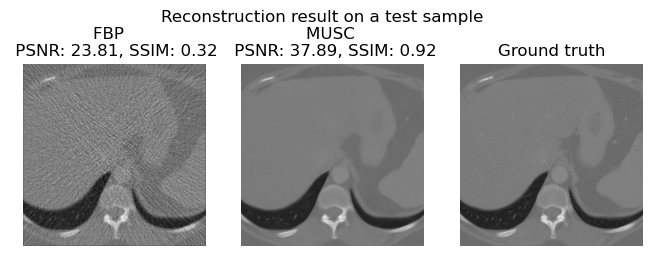

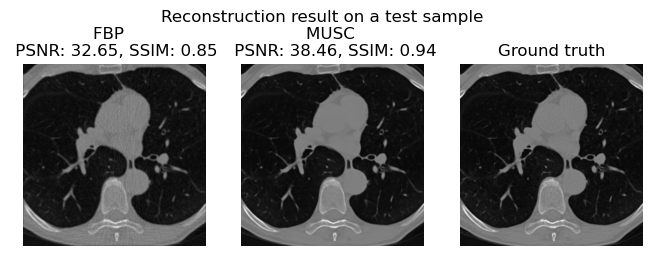

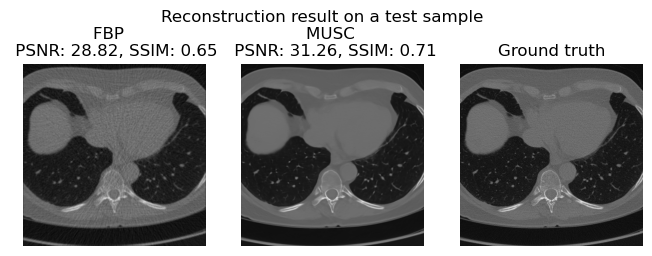

In [6]:
for sample_at in range(3):
    # sample_at = 1
    obs, gt = next(itertools.islice(loaders_bs1['test'], sample_at, None))

    recon = model(obs.to(device)).cpu().detach().numpy()
    # evaluate w/ psnr and ssim

    obs_psnr = PSNR(obs, gt)
    musc_psnr = PSNR(recon, gt)

    obs_ssim = SSIM(obs[0,0].numpy(), gt[0,0].numpy())
    musc_ssim = SSIM(recon[0,0], gt[0,0].numpy())

    _, ax = plot_images([obs.cpu()[0,0], recon[0,0], gt.cpu()[0,0]], fig_size=(8, 3), cbar = 'none')
    ax[0].set_title('FBP  \n PSNR: {:.2f}, SSIM: {:.2f}'.format(obs_psnr, obs_ssim) )
    ax[0].axis('off')
    ax[1].set_title('MUSC \n PSNR: {:.2f}, SSIM: {:.2f}'.format(musc_psnr, musc_ssim))
    ax[1].axis('off')
    ax[2].set_title('Ground truth')
    ax[2].axis('off')

    ax[1].figure.suptitle('Reconstruction result on a test sample')

In [7]:
# obs_list = []
# gt_list = []
# for sample_at in range(10):
#     obs, gt = next(itertools.islice(loaders_bs1['test'], sample_at, None))
#     obs_list.append(obs)
#     gt_list.append(gt)

# torch.save({'obs': torch.cat(obs_list), 'gt': torch.cat(gt_list)}, '10_lodopab_ct_test_samples.pt')

## Visualizing atoms

In [8]:
def crop_nz_atom(atom):
  "extract the non-zero part of the atom"
  indices_dim0, indices_dim1 = torch.nonzero(atom, as_tuple = True)

  dim0_max = indices_dim0.max().detach().numpy()
  dim0_min = indices_dim0.min().detach().numpy()
  dim1_max = indices_dim1.max().detach().numpy()
  dim1_min = indices_dim1.min().detach().numpy()

  nz_atom = atom[dim0_min:dim0_max+1, dim1_min:dim1_max+1]
  return nz_atom


def normalize_atom(atom):
  "normalize the atom to [-1, 1]"
  return 2 * (atom -atom.min() )/ ( atom.max() - atom.min()) - 1


def extract_atoms(model, dict_str = 'decoder_dictionary', num_atoms = 6):
  """extract atoms from the model"""
  if dict_str not in ['encoder_dictionary', 'precond_encoder_dictionary',
                      'decoder_dictionary']:
    raise ValueError('the dictionary is not defined')
  else:
    called_dictionary = getattr(model, dict_str)

  all_zero_code = model.adjoint_precond_encoder_dictionary(
     torch.zeros(1, 1, 128, 128).to(device))

  all_layers_crop_atom_list = []

  for layer_idx in range(len(model.hidden_layer_widths)):
    atom_list = []
    num_channels = all_zero_code[layer_idx].shape[1]
    for entry_idx in range(num_channels):
      indicator_sparse_code = [a.clone() for a in all_zero_code]
      dim0, dim1 = indicator_sparse_code[layer_idx][0, entry_idx].shape
      indicator_sparse_code[
        layer_idx][0, entry_idx, int(dim0/2), int(dim1/2)].fill_(1)
      atom = called_dictionary(indicator_sparse_code).squeeze().cpu().detach()
      atom_list.append(atom)

    large_norm_indices = torch.topk(torch.Tensor(
      [torch.norm(a).item() for a in atom_list ]), num_atoms).indices

    atom_list = [atom_list[a] for a in large_norm_indices]

    crop_atom_list = [crop_nz_atom(atom) for atom in atom_list]

    all_layers_crop_atom_list.append(crop_atom_list)

  dim_list = [item[0].shape[0] for item in all_layers_crop_atom_list][::-1]
  flatten_atom_list = [
    item for items in all_layers_crop_atom_list for item in items][::-1]

  flatten_atom_list = [
    normalize_atom(atom) for atom in flatten_atom_list]
  return flatten_atom_list, dim_list

In [9]:
NUM_ATOMS = 6

learned_atoms, dim_list = extract_atoms(
  model, dict_str = 'decoder_dictionary', num_atoms=NUM_ATOMS)

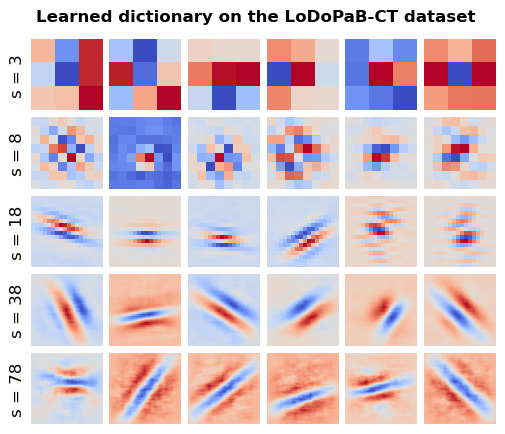

In [10]:

fontsize = 12

fig = plt.figure()

img, axes = plot_images(
    learned_atoms,
    fig = fig,
    nrows=5,
    ncols=-1,
    fig_size=(NUM_ATOMS, 5),
    cbar = 'none', cmap = 'coolwarm');

[remove_frame(ax) for ax in axes.flatten()]

for i in range(5):
    axes[i][0].set_ylabel(r"s = " + str(dim_list[i]), fontsize = fontsize)

plt.suptitle(
  "Learned dictionary on the LoDoPaB-CT dataset",
  y=0.94,  weight = 'bold', fontsize = fontsize);
fig.subplots_adjust(wspace=0.1, hspace=0.1)